### Autoencoder 
 

#### Linear autoencoder
* The layers that are used have no activation function

#### Non-linear autoencoder
* The layers that are used have non-linear activation function

In [11]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


**Loading data file**

In [12]:
data_f = pd.read_csv(
    '~/ml_J1-J2_supervised/all_phase/af/augumented_dataL24.csv',index_col=[0])


print(data_f.shape)


(80000, 577)


In [13]:
data_f.head()

,spin0,spin1,spin2,spin3,spin4,spin5,spin6,spin7,spin8,spin9,...,spin567,spin568,spin569,spin570,spin571,spin572,spin573,spin574,spin575,label
0,-1,1,-1,1,-1,1,-1,1,-1,1,...,-1,1,-1,1,-1,1,-1,1,-1,0
1,1,-1,1,-1,1,-1,1,-1,1,-1,...,1,-1,1,-1,1,-1,1,-1,1,0
2,-1,1,-1,1,-1,1,-1,1,-1,1,...,-1,1,-1,1,-1,1,-1,1,-1,0
3,1,-1,1,-1,1,-1,1,-1,1,-1,...,1,-1,1,-1,1,-1,1,-1,1,0
4,-1,1,-1,1,-1,1,-1,1,-1,1,...,-1,1,-1,1,-1,1,-1,1,-1,0


In [14]:
X_train,X_test,y_train,y_test = train_test_split(data_f.iloc[:,:-1]\
    ,data_f.iloc[:,-1:],test_size=0.2,stratify=data_f.iloc[:,-1:],random_state=42)

In [15]:
train_combined = pd.concat([X_train,y_train],axis=1)
test_combined = pd.concat([X_test,y_test],axis=1)


**Set the cpu as the device**

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Load the data using class dataset**

In [17]:
## class to load the data
## x_data has all the features
## y_data has data labels

class LoadData(Dataset):
    def __init__(self,data,L,device=device):
        self.L=L
        self.x_data = torch.tensor(data.iloc[:,:int(self.L**2)].values,dtype=torch.float32).to(device=device)
        self.y_data = torch.tensor(data.iloc[:,int(self.L**2):].values,dtype=torch.long).to(device=device)

    ### length of the dataset
    ### function one has to define for using custom dataset classes
    def __len__(self):
        return len(self.y_data)

    ### get the image and label during the training
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        image = self.x_data[idx,:]
        label = self.y_data[idx]
        return {'data':image,'label':label}





**Model definition for both linear and non-linear autoencoder**

In [18]:
### object blue print for the linear autoencoder model (no activation function)
class linearModel(nn.Module):

    ## initializing the object
    def __init__(self,input_size,latent_dim):
        ## inheriting init of the nn.Module class
        super(linearModel,self).__init__()
        
        ## encoder network
        self.encoder1 = nn.Linear(in_features = input_size,out_features=256)
        self.encoder2 = nn.Linear(in_features=256,out_features=128)
        self.encoder3 = nn.Linear(in_features=128,out_features=64)
        self.encoder4 = nn.Linear(in_features=64,out_features=32)
        self.encoder5 = nn.Linear(in_features=32,out_features=latent_dim)

        ## decoder network
        self.decoder1 = nn.Linear(in_features=latent_dim,out_features=32)
        self.decoder2 = nn.Linear(in_features=32, out_features=64)
        self.decoder3 = nn.Linear(in_features=64, out_features=128)
        self.decoder4 = nn.Linear(in_features=128, out_features=256)
        self.decoder5 = nn.Linear(in_features=256, out_features=input_size)

    ### function to perform the forward pass
    def forward(self,x):

        ## passing input through the encoder network
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)
        x = self.encoder5(x)

        ## passing the latent representation obtained through the encoder 
        ## network to the decoder network
        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)
        x = self.decoder5(x)

        return x


### definitin of class for the non-linear autoencoder(relu activation function)
class nonLinearmodel(nn.Module):
    ## initializing the object
    def __init__(self,input_size,latent_dim):
        super(nonLinearmodel,self).__init__()
        ## encoder network
        self.encd1 = nn.Linear(in_features=input_size,out_features=256)
        self.encd2 = nn.Linear(in_features=256,out_features=128)
        self.encd3 = nn.Linear(in_features=128,out_features=64)
        self.encd4 = nn.Linear(in_features=64,out_features=32)
        self.encd5 = nn.Linear(in_features=32,out_features=latent_dim)


        ## decoder network
        self.decd1 = nn.Linear(in_features=latent_dim,out_features=32)
        self.decd2 = nn.Linear(in_features=32,out_features=64)
        self.decd3 = nn.Linear(in_features=64,out_features=128)
        self.decd4 = nn.Linear(in_features=128,out_features=256)
        self.decd5 = nn.Linear(in_features=256,out_features=input_size)


    ## defining function for the forward pass
    def forward(self,x):
        ## input flowing from the encoder layers
        x = torch.tanh(self.encd1(x))
        x = torch.tanh(self.encd2(x))
        x = torch.tanh(self.encd3(x))
        x = torch.tanh(self.encd4(x))
        x = torch.tanh(self.encd5(x))

        ## compressed representation flowing through the decoding layers
        x = torch.tanh(self.decd1(x))
        x = torch.tanh(self.decd2(x))
        x = torch.tanh(self.decd3(x))
        x = torch.tanh(self.decd4(x))
        x = torch.tanh(self.decd5(x))
        return x

**Parameters for the problem**

In [19]:
L = 24
input_size = int(L* L)
latent_dim = 24
learning_rate = 0.001
batch_size = 800
num_epochs = 1

**Data loader object**

In [20]:
## creating an object of class dataload for both training data and test data
train_data = LoadData(train_combined,L,device)
test_data = LoadData(test_combined, L, device)

## create a data iterator for training data and testing data
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)    
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=False)    

**Function that trains the model and saves the loss as well as the model predictions**

In [21]:
### program to train the model and calculate the training error 
def modeltraining(model,data_loader,loss_fn,optimizer):
    size = len(data_loader.dataset)
    model.train()
    train_loss = []
    train_step = []
    for batch_idx,batch in enumerate(data_loader):
        data = batch['data'].to(device=device)
       
        ## forward pass
        preds = model(data)

        ## calculate the loss
        loss = loss_fn(preds,data)

        ## backpropagation setting up the gradient to zero
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_step.append(batch_idx)
    return {'step':np.array(train_step),'loss':np.array(train_loss)}

### program to test the model and claculate the testing error
def modeltest(model,dataloader,loss_fn,epochs,num_epochs,f1name,f2name):
    size=len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = []
    with torch.no_grad():
        for batch_idx,batch in enumerate(dataloader):
            data = batch['data'].to(device)
            pred = model(data)
            loss = loss_fn(pred,data).item()

            test_loss.append(loss)
            if ((epochs == num_epochs-1) & (batch_idx==num_batches-1)):
                print("last one")
                np.save(f1name,data.numpy())
                np.save(f2name,pred.numpy())
    return test_loss    


**Using a linear autoencoder**

In [22]:
## instantiating the linear autoencoder
lnrencd = linearModel(input_size,latent_dim)
print(lnrencd)


## setting up the mean-squared error
mse = nn.MSELoss()

## setting up the optimizer
optimizer = optim.Adam(lnrencd.parameters(),lr=learning_rate)

## training the and testing the linear autoencoder
tr_loss={}
tst_loss={}
for t in range(num_epochs):
    rtr = modeltraining(lnrencd, train_dataloader, mse,optimizer)
    tr_loss[t]=rtr['loss']
    tst_loss[t] = modeltest(lnrencd, test_dataloader,mse,t,num_epochs,'lnrencdata','lnrencpred')
    



linearModel(
  (encoder1): Linear(in_features=576, out_features=256, bias=True)
  (encoder2): Linear(in_features=256, out_features=128, bias=True)
  (encoder3): Linear(in_features=128, out_features=64, bias=True)
  (encoder4): Linear(in_features=64, out_features=32, bias=True)
  (encoder5): Linear(in_features=32, out_features=24, bias=True)
  (decoder1): Linear(in_features=24, out_features=32, bias=True)
  (decoder2): Linear(in_features=32, out_features=64, bias=True)
  (decoder3): Linear(in_features=64, out_features=128, bias=True)
  (decoder4): Linear(in_features=128, out_features=256, bias=True)
  (decoder5): Linear(in_features=256, out_features=576, bias=True)
)
last one


**Using a non-linear auto encoder**

In [23]:
## instantiate non-linear autoencoder
nonlnrmodel  = nonLinearmodel(input_size, latent_dim)

## setting up the mean-squared error
mse = nn.MSELoss()

## setting up the optimizer
optimizer = optim.Adam(nonlnrmodel.parameters(), lr=learning_rate)

print(nonlnrmodel)

### training the model
tr_loss = {}
tst_loss = {}
for t in range(num_epochs):
    rtr = modeltraining(nonlnrmodel, train_dataloader, mse, optimizer)
    tr_loss[t] = rtr['loss']
    tst_loss[t] = modeltest(nonlnrmodel, test_dataloader, mse,t,num_epochs,'nlnrencdata','nlnrencpred')


nonLinearmodel(
  (encd1): Linear(in_features=576, out_features=256, bias=True)
  (encd2): Linear(in_features=256, out_features=128, bias=True)
  (encd3): Linear(in_features=128, out_features=64, bias=True)
  (encd4): Linear(in_features=64, out_features=32, bias=True)
  (encd5): Linear(in_features=32, out_features=24, bias=True)
  (decd1): Linear(in_features=24, out_features=32, bias=True)
  (decd2): Linear(in_features=32, out_features=64, bias=True)
  (decd3): Linear(in_features=64, out_features=128, bias=True)
  (decd4): Linear(in_features=128, out_features=256, bias=True)
  (decd5): Linear(in_features=256, out_features=576, bias=True)
)
last one


In [24]:
f = plt.figure()
sns.lineplot(x='step',y='loss',data=df_lnr,label='Linear Encoder')
sns.lineplot(x='step', y='loss', data=df_nlnr,label = 'None linear Encoder')
plt.xlabel('Training steps')
plt.ylabel('MSE loss')
plt.show()

NameError: name 'df_lnr' is not defined

<Figure size 432x288 with 0 Axes>

In [26]:
### loading data for the linear autoencoder
lnrencdt=np.load('lnrencdata.npy')
lnrencprd=np.load('lnrencpred.npy')

## loading data for the non-linear autoencoder
nlnrencdt=np.load('nlnrencdata.npy')
nlnrencprd=np.load('nlnrencpred.npy')

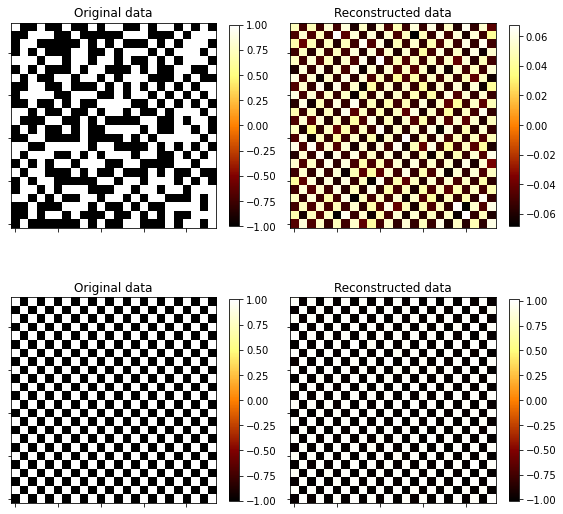

In [40]:
def plot_latt(data1,data2,num1,num2,L):
    f,ax=plt.subplots(2,2,figsize=(8,8))
    im1 = ax[0,0].imshow(data1[num1,:].reshape(L,L),origin='lower',cmap='afmhot')
    ax[0,0].set_title('Original data')
    ax[0,0].set_yticklabels([])
    ax[0, 0].set_xticklabels([])

    f.colorbar(im1,ax=ax[0,0],shrink=0.72)

    im2 = ax[0, 1].imshow(data2[num1, :].reshape(L, L), origin='lower', cmap='afmhot')
    ax[0, 1].set_title('Reconstructed data')
    f.colorbar(im2, ax=ax[0, 1], shrink=0.72)
    ax[0,1].set_yticklabels([])
    ax[0, 1].set_xticklabels([])

    im3 = ax[1, 0].imshow(data1[num2, :].reshape(L, L), origin='lower', cmap='afmhot')
    ax[1, 0].set_title('Original data')
    f.colorbar(im3, ax=ax[1, 0], shrink=0.72)
    ax[1,0].set_yticklabels([])
    ax[1, 0].set_xticklabels([])

    im4 = ax[1, 1].imshow(data2[num2, :].reshape(L, L), origin='lower', cmap='afmhot')
    ax[1, 1].set_title('Reconstructed data')
    f.colorbar(im4, ax=ax[1, 1], shrink=0.72) 
    ax[1,1].set_yticklabels([])
    ax[1, 1].set_xticklabels([])
    plt.tight_layout()
    plt.show()

plot_latt(lnrencdt,lnrencprd,10,440,24)


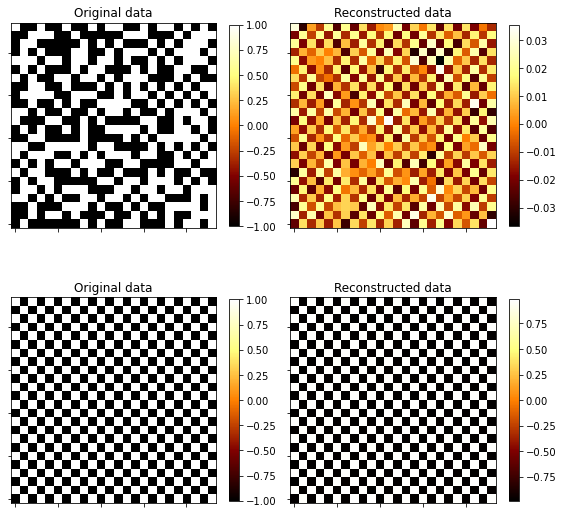

In [41]:
plot_latt(nlnrencdt,nlnrencprd,10,440,24)

Parameter containing:
tensor([[ 7.3155e-02,  7.3006e-02,  1.6098e-02,  ..., -1.2895e-04,
          6.7736e-02, -1.4897e-02],
        [-1.0383e-02, -1.1813e-01,  7.0039e-02,  ..., -4.8130e-02,
         -3.4877e-02,  1.0401e-01],
        [ 9.5662e-02,  1.8439e-02,  4.1079e-02,  ...,  6.0020e-02,
          1.1135e-01,  3.1035e-02],
        ...,
        [ 1.3502e-01, -8.2800e-02,  1.0141e-01,  ..., -1.7149e-03,
          9.2578e-02, -2.6042e-02],
        [ 1.0252e-01,  5.0527e-02, -4.5917e-02,  ..., -9.7155e-02,
         -9.0206e-02, -2.2110e-02],
        [ 1.1797e-01, -6.3416e-03,  5.6589e-02,  ...,  7.2624e-02,
          1.8964e-02, -5.4672e-02]], requires_grad=True)